# Test de méthodes pour rassembler les modèles

## Imports

In [61]:
from sklearn.ensemble import VotingClassifier
from joblib import load
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,accuracy_score, cohen_kappa_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns


In [62]:
def load_probas_from_csv(file_path):
    """
    Loads probabilities from a CSV file and returns them as a numpy array.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except ValueError as e:
        print(f"Error reading probabilities CSV file: {e}")
        return None

## Reading data

### VERSION 1

In [156]:

rf_prob = load_probas_from_csv('predictions/rf_proba.csv')
xgb_prob = load_probas_from_csv('predictions/xgb_proba.csv')
# smiles_prob = load_probas_from_csv('predictions/smiles_proba.csv')
# smiles_prob = load_probas_from_csv('predictions/gcn_proba.csv')


meta_features = pd.concat([
    rf_prob.iloc[:, 1],
    xgb_prob.iloc[:, 1],
    # smiles_prob.iloc[:, 1]
], axis=1)
meta_features.columns = [ 'rf', 'xgb']

y = pd.read_csv('data/train_data_20.csv')['class'].values

X_train, X_test, y_train, y_test = train_test_split(meta_features, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Training set size: 1506, Test set size: 377


### VERSION 2

In [63]:
FP_XGB_prob = load_probas_from_csv('predictions/FP_XGB.csv')
GNN_prob = load_probas_from_csv('predictions/predictions_GNN.csv')
mlp_desc_prob = load_probas_from_csv('predictions/mlp_desc_proba.csv')
smiles_prob = load_probas_from_csv('predictions/smiles_proba3.csv')

meta_features = pd.concat([
    FP_XGB_prob.iloc[:, 1], 
    GNN_prob.iloc[:, 1],
    mlp_desc_prob.iloc[:, 1],
    smiles_prob.iloc[:, 1]
], axis=1)
meta_features.columns = [ 'fp_xgb', 'gnn', 'mlp', 'smiles']

y = pd.read_csv('data/train_data_20.csv')['class'].values

X_train, X_test, y_train, y_test = train_test_split(meta_features, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Training set size: (1506, 4), Test set size: (377, 4)


In [ ]:
# Analyser les différences entre les modèles
def compare_probas(probas, y_true):
    """
    Compare the predicted probabilities of different models.
    args:
        probas DataFrame: DataFrame of predicted probabilities from different models.
        y_true (np.array): True labels.
    """
    for i, proba in enumerate(probas):
        y_pred = np.argmax(proba, axis=1)
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f"Model {i+1} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
        print(classification_report(y_true, y_pred))
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f'Confusion Matrix for Model {i+1}')
        plt.show()

In [104]:
def compare_probas(probas, y_true):
    """
    Compare les probabilités prédites par différents modèles et analyse leurs similarités.
    
    Args:
        probas (DataFrame): DataFrame contenant les probabilités de classe 1 pour chaque modèle.
                           Les colonnes sont les noms des modèles, les lignes sont les échantillons.
        y_true (pd.Series or np.array): Étiquettes vraies (0 ou 1).
    
    Returns:
        dict: Dictionnaire contenant les différentes analyses.
    """
    results = {}
    
    # 1. Conversion des probas en prédictions (seuil à 0.5)
    predictions = probas.applymap(lambda x: 1 if x >= 0.5 else 0)
    
    # 2. Calcul des erreurs grossières (où les modèles se trompent violemment)
    treshold = 0.9
    errors = {}
    for model in probas.columns:
        # Cas où le modèle est très confiant mais incorrect
        high_conf_wrong = ((probas[model] > treshold) & (y_true == 0)) | ((probas[model] < 1 - treshold) & (y_true == 1))
        errors[model] = {
            'count': high_conf_wrong.sum(),
            'percentage': high_conf_wrong.mean() * 100,
            'indices': high_conf_wrong[high_conf_wrong].index.tolist()
        }
    
    results['gross_errors'] = errors
    
    # 3. Matrice de corrélation entre les probas des modèles
    corr_matrix = probas.corr()
    results['correlation_matrix'] = corr_matrix
    
    # 4. Différences absolues moyennes entre les modèles
    from itertools import combinations
    diff_results = {}
    for (model1, model2) in combinations(probas.columns, 2):
        diff = np.mean(np.abs(probas[model1] - probas[model2]))
        diff_results[f"{model1} vs {model2}"] = diff
    results['mean_absolute_differences'] = diff_results
    
    # 5. Pourcentage de prédictions identiques (au seuil 0.5)
    agreement_results = {}
    for (model1, model2) in combinations(predictions.columns, 2):
        agreement = np.mean(predictions[model1] == predictions[model2])
        agreement_results[f"{model1} vs {model2}"] = agreement * 100
    results['prediction_agreement'] = agreement_results
    
    return results

def plot_comparison_results(results):
    """Visualise les résultats de la comparaison."""
    
    # 1. Plot des erreurs grossières
    errors_df = pd.DataFrame({model: [results['gross_errors'][model]['percentage']] 
                             for model in results['gross_errors']})
    plt.figure(figsize=(10, 5))
    sns.barplot(data=errors_df)
    plt.title("Pourcentage d'erreurs grossières (confiance > treshold mais prédiction incorrecte)")
    plt.ylabel("Pourcentage")
    plt.show()
    
    # 2. Heatmap de corrélation
    plt.figure(figsize=(8, 6))
    sns.heatmap(results['correlation_matrix'], annot=True, cmap='coolwarm', vmin=0, vmax=1)
    plt.title("Corrélation entre les probabilités des modèles")
    plt.show()
    
    # 3. 
    diff_df = pd.DataFrame.from_dict(results['mean_absolute_differences'], 
                                   orient='index', columns=['Difference'])
    diff_df.plot(kind='bar', figsize=(10, 5), legend=False)
    plt.title("Différence absolue moyenne entre les probabilités des modèles")
    plt.ylabel("Différence moyenne")
    plt.show()

    # 4. 
    # diff_df = pd.DataFrame.from_dict(results['prediction_agreement'],
    #                                orient='index', columns=['Agreement (%)']) 
    # diff_df.plot(kind='bar', figsize=(10, 5), legend=False)
    # plt.title("Pourcentage d'accord entre les prédictions des modèles")
    # plt.ylabel("Pourcentage d'accord")
    # plt.show()

C:\Users\nonoa\AppData\Local\Temp\ipykernel_2432\92678812.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  predictions = probas.applymap(lambda x: 1 if x >= 0.5 else 0)


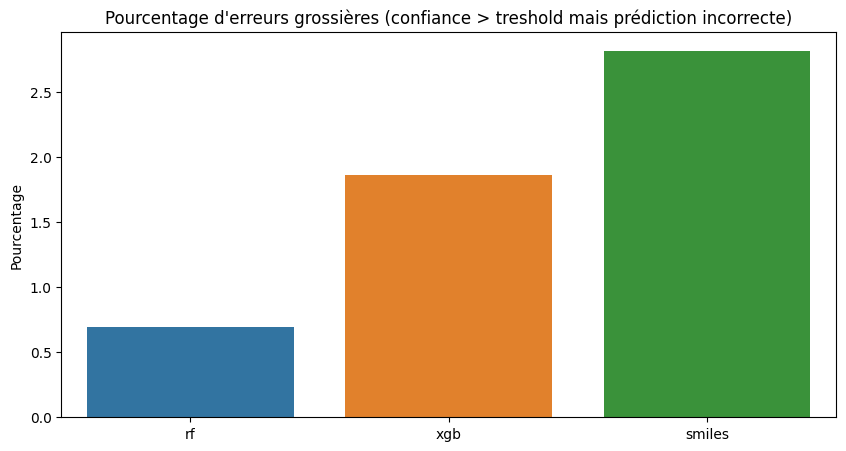

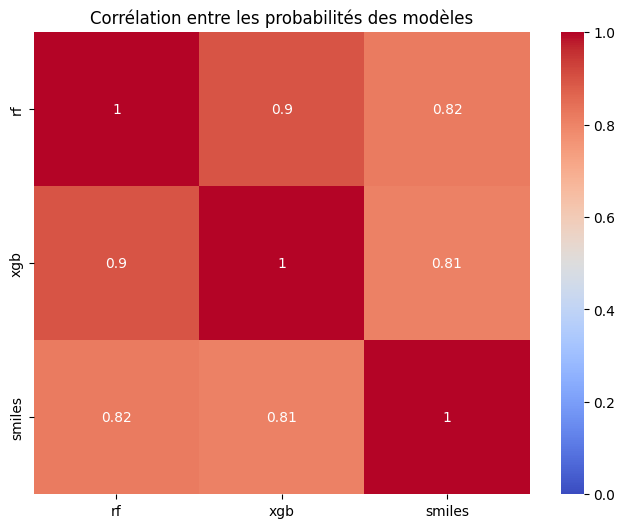

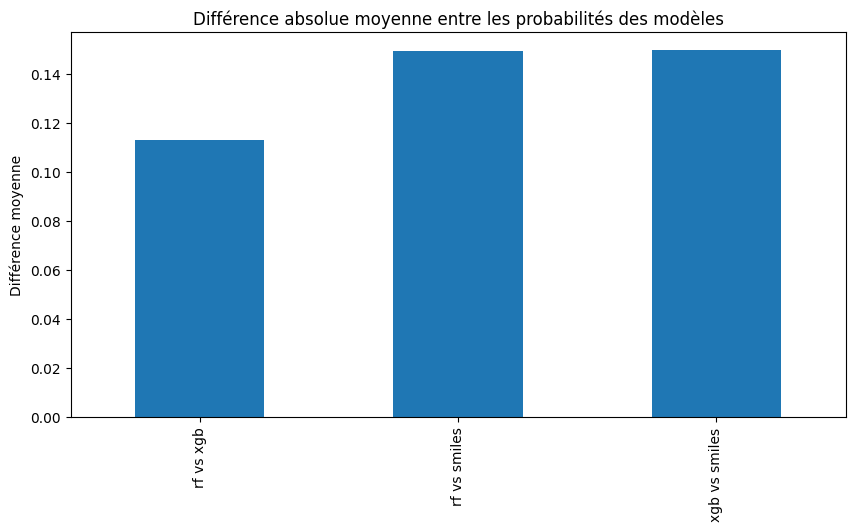

In [105]:
results = compare_probas(meta_features, y)
plot_comparison_results(results)

### Calcul de coefficient de confiance pour chaque modèle

In [106]:
def compute_confidence_score(y_true, y_proba):
    """
    Calcule un coefficient de confiance pour un modèle de classification binaire.
    
    Args:
        y_true (array): Vraies étiquettes (0 ou 1).
        y_proba (array): Probabilités prédites pour la classe 1 (entre 0 et 1).
    
    Returns:
        float: Score de confiance entre 0 (pas confiant) et 1 (très confiant).
    """
    # Convertir y_true en array numpy au cas où
    y_true = np.array(y_true)
    y_proba = np.array(y_proba)
    
    # Calculer la "confiance" comme la moyenne de 1 - |y_true - y_proba|
    confidence = 1 - np.mean(np.abs(y_true - y_proba))
    
    return round(confidence, 4)

In [107]:
def compare_models_confidence(probas_df, y_true):
    """Calcule le score de confiance pour chaque modèle."""
    confidence_scores = []
    for model in probas_df.columns:
        confidence_scores.append(compute_confidence_score(y_true, probas_df[model]))
    return confidence_scores

In [130]:
confidence_scores = compare_models_confidence(meta_features, y)
print(confidence_scores)

[np.float64(0.7588), np.float64(0.737)]


### Entraînement d'un decision tree

Fitting 5 folds for each of 36 candidates, totalling 180 fits
✅ Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


Classification Report:
              precision    recall  f1-score   support

     Class 0     0.8112    0.8503    0.8303       187
     Class 1     0.8453    0.8053    0.8248       190

    accuracy                         0.8276       377
   macro avg     0.8283    0.8278    0.8275       377
weighted avg     0.8284    0.8276    0.8275       377

Cohen's Kappa Score: 0.6553


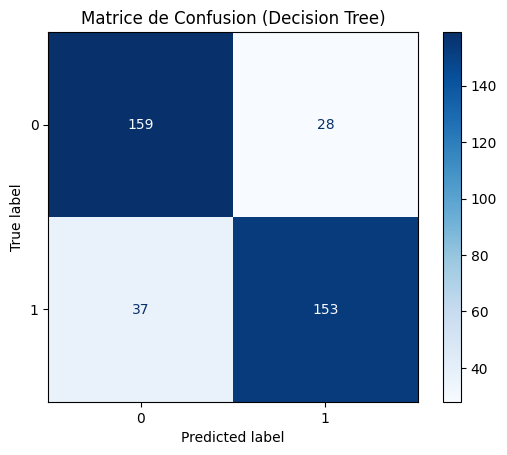

In [109]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay

# Définir le modèle de base
model = DecisionTreeClassifier(random_state=42)

# Définir une grille simple de recherche
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Lancer la recherche par validation croisée (sans group CV ici pour simplicité)
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Entraînement
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print("✅ Best parameters:", grid.best_params_)

# Prédiction
y_pred = best_model.predict(X_test)

# Rapport de classification
print("\n\nClassification Report:")
print("========================================")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=4))

# Kappa
kappa_score = cohen_kappa_score(y_pred, y_test)
print(f"Cohen's Kappa Score: {kappa_score:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion (Decision Tree)')
plt.show()


In [70]:
print(X_train.shape, X_test.shape)

(1506, 4) (377, 4)


### Moyenne des probas

In [ ]:
def tqt(metafeature, method='majority', weights=None):
    """
    Prend une décision binaire à partir d'une liste de prédictions ou de probabilités.

    - majority : vote majoritaire. En cas d'égalité, on choisit la classe avec la plus grande somme de confiance.
    - mean     : moyenne avec seuil à 0.5
    - average  : moyenne pondérée
    """
    metafeature = np.array(metafeature)

    if method == 'majority':
        # Convertir en classes 0/1 (par exemple à partir de probas)
        bin_preds = (metafeature >= 0.5).astype(int)
        votes_0 = np.sum(bin_preds == 0)
        votes_1 = np.sum(bin_preds == 1)

        if votes_1 > votes_0:
            return 1
        elif votes_0 > votes_1:
            return 0
        else:
            # Égalité → choisir la classe avec plus de confiance totale
            conf_1 = np.sum(metafeature[bin_preds == 1])
            conf_0 = np.sum(1 - metafeature[bin_preds == 0])
            return int(conf_1 >= conf_0)

    elif method == 'mean':
        return np.mean(metafeature)

    elif method == 'average':
        if weights is None:
            raise ValueError("Pour 'average', weights est requis.")
        return int(np.average(metafeature, weights=weights) >= 0.5)

    else:
        raise ValueError("Méthode invalide. Choisir 'majority', 'mean' ou 'average'.")


In [135]:
y_pred = [tqt(meta_feature, method='average', weights=confidence_scores) for meta_feature in meta_features.values]
print(np.mean(y_pred == y))
print(cohen_kappa_score(y_pred, y))


0.838024429102496
0.6762118622997659


In [136]:
y_pred = [tqt(meta_feature, method='mean') for meta_feature in meta_features.values]
print(np.mean(y_pred == y))
print(cohen_kappa_score(y_pred, y))


0.838024429102496
0.6762118622997659


In [137]:
y_pred = [tqt(meta_feature, method='majority', weights=confidence_scores) for meta_feature in meta_features.values]
print(np.mean(y_pred == y))
print(cohen_kappa_score(y_pred, y))


0.838024429102496
0.6762118622997659


# TEST 1

C:\Users\nonoa\AppData\Local\Temp\ipykernel_2432\161331761.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=y_pred_test_1, x='class', palette='pastel')


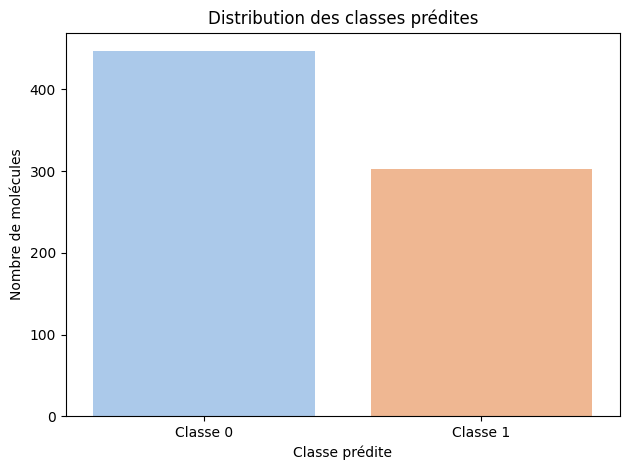

                                              SMILES  class
0                      Brc1cccc2nc(C#Cc3ccccn3)ccc12      0
1           C#CC1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3CCC21C      0
2  C#CC1CCC(C#N)N1C(=O)CNC1(C)CCN(c2cc(C(=O)O)ccn...      0
3                    C#CCN(C)CC1=Cc2ccccc2Oc2ccccc21      1
4  C#Cc1cc(-c2n[nH]c3c2Cc2cc(CN4CCN(C)CC4)ccc2-3)cs1      1


In [94]:
FP_XGB_prob = load_probas_from_csv('pred_sur_test/prediction_xgb.csv')
GNN_prob = load_probas_from_csv('pred_sur_test/predictions_gnn.csv')
mlp_desc_prob = load_probas_from_csv('pred_sur_test/prediction_mlp.csv')
smiles_prob = load_probas_from_csv('pred_sur_test/predictions_trf.csv')

meta_features = pd.concat([
    FP_XGB_prob.iloc[:, 1], 
    GNN_prob.iloc[:, 1],
    mlp_desc_prob.iloc[:, 1],
    smiles_prob.iloc[:, 1]
], axis=1)
meta_features.columns = [ 'fp_xgb', 'gnn', 'mlp', 'smiles']


y_pred = [tqt(meta_feature, method='mean', weights=confidence_scores) for meta_feature in meta_features.values]
y_pred_test_1 = pd.DataFrame({'SMILES' : FP_XGB_prob.iloc[:, 0], 'class' : y_pred})

# Assure que la colonne 'class' est bien numérique
y_pred_test_1['class'] = y_pred_test_1['class'].astype(int)

# Barplot
sns.countplot(data=y_pred_test_1, x='class', palette='pastel')
plt.title("Distribution des classes prédites")
plt.xlabel("Classe prédite")
plt.ylabel("Nombre de molécules")
plt.xticks([0, 1], ['Classe 0', 'Classe 1'])
plt.tight_layout()
plt.show()

print(y_pred_test_1.head())



### version 1

C:\Users\nonoa\AppData\Local\Temp\ipykernel_2432\3466050958.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=y_pred_test_1, x='class', palette='pastel')


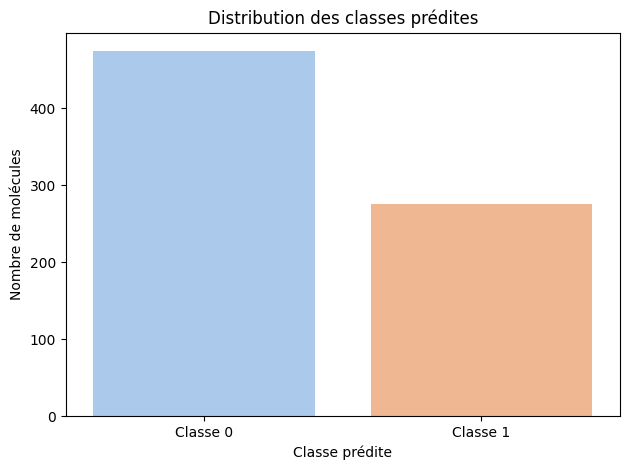

                                              smiles  class
0                      Brc1cccc2nc(C#Cc3ccccn3)ccc12      0
1           C#CC1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3CCC21C      0
2  C#CC1CCC(C#N)N1C(=O)CNC1(C)CCN(c2cc(C(=O)O)ccn...      0
3                    C#CCN(C)CC1=Cc2ccccc2Oc2ccccc21      1
4  C#Cc1cc(-c2n[nH]c3c2Cc2cc(CN4CCN(C)CC4)ccc2-3)cs1      1


In [154]:
rf_prob = load_probas_from_csv('predictions/lgbm_proba_test_1.csv')
xgb_prob = load_probas_from_csv('predictions/xgb_proba_test_1.csv')


meta_features = pd.concat([
    rf_prob.iloc[:, 1],
    xgb_prob.iloc[:, 1],
    # smiles_prob.iloc[:, 1]
], axis=1)
meta_features.columns = [ 'rf', 'xgb']


y_pred_proba = np.array([tqt(meta_feature, method='mean', weights=confidence_scores) for meta_feature in meta_features.values])
y_pred = np.array([1 if proba >= 0.5 else 0 for proba in y_pred_proba]).astype(int)

y_pred_test_1 = pd.DataFrame({'smiles' : FP_XGB_prob.iloc[:, 0], 'class' : y_pred})

# Assure que la colonne 'class' est bien numérique
y_pred_test_1['class'] = y_pred_test_1['class'].astype(int)

# Barplot
sns.countplot(data=y_pred_test_1, x='class', palette='pastel')
plt.title("Distribution des classes prédites")
plt.xlabel("Classe prédite")
plt.ylabel("Nombre de molécules")
plt.xticks([0, 1], ['Classe 0', 'Classe 1'])
plt.tight_layout()
plt.show()

print(y_pred_test_1.head())



In [141]:
y_pred_test_1.to_csv('predictions/meta_test_1.csv', index=False)

In [100]:
def compare_csv_files(file1, file2):
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    # Vérifier les colonnes
    if set(df1.columns) != set(df2.columns):
        print("Les fichiers CSV n'ont pas les mêmes colonnes.")
        return

    # Comparer les valeurs
    differences = df1.compare(df2)

    if differences.empty:
        print("Les fichiers CSV sont identiques.")
    else:
        print("Différences trouvées :")
        print(differences)
        print(f"Nombre de différences : {len(differences)}")

    y_1 = df1['class'].values
    y_2 = df2['class'].values
    print(np.sum(y_1 == 0), np.sum(y_1 == 1))
    print(np.sum(y_2 == 0), np.sum(y_2 == 1))

In [155]:
compare_csv_files('pred_final/pred_1.csv', 'predictions/meta_test_1.csv')

Différences trouvées :
                                                smiles  \
                                                  self   
0                        Brc1cccc2nc(C#Cc3ccccn3)ccc12   
1             C#CC1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3CCC21C   
2    C#CC1CCC(C#N)N1C(=O)CNC1(C)CCN(c2cc(C(=O)O)ccn...   
3                      C#CCN(C)CC1=Cc2ccccc2Oc2ccccc21   
4    C#Cc1cc(-c2n[nH]c3c2Cc2cc(CN4CCN(C)CC4)ccc2-3)cs1   
..                                                 ...   
745                       c1cn(C2CCCCC2)nc1OCCN1CCOCC1   
746               c1cnc(Nc2nc3c(s2)CCCc2[nH]ncc2-3)nc1   
747                c1cnc2nc(Oc3ccc(CN4CCCCC4)cc3)sc2c1   
748         c1cncc(-c2ccc(-c3noc(C4CN5CCC4CC5)n3)o2)c1   
749                   c1cncc(-c2ccccc2OC2CC3CNCC2C3)c1   

                                                class        
                                          other  self other  
0                  c1ccc(Cc2ncc3c(n2)CCNCC3)cc1   NaN   NaN  
1             c1ccc(COc2ccc(CCNc3ccn

In [ ]:

y_dist = pd.DataFrame({
    'smiles': y_pred_test_1['smiles'],
    'diff': np.abs(y_pred_proba - y_pred),
    'class': y_pred_test_1['class']
})

# Trier le DataFrame par ordre croissant des différences
y_dist_sorted = y_dist.sort_values(by='diff')




y_final = y_dist_sorted.drop(columns=['diff'])

print(y_final.head(20))

y_final.to_csv('predictions/meta_test_2.csv', index=False)




                                                smiles  class
735                       c1ccc(Cc2ncc3c(n2)CCNCC3)cc1      0
734                  c1ccc(COc2ccc(CCNc3ccncc3)cc2)cc1      1
733                c1ccc(CN(c2cccc3sccc23)C2CCNCC2)cc1      1
732                  c1ccc(CC2(c3ccc4sccc4c3)CCNC2)cc1      1
731                c1ccc(-n2cc(-c3ccnc4ccccc34)cn2)cc1      0
730            c1ccc(-c2cnc(Nc3cc(CN4CCCC4)ccn3)s2)cc1      1
729       c1cc2c(cc1C1OCC3C(c4ccc5c(c4)OCO5)OCC13)OCO2      0
728                     c1cc(N2CCCCC2)ccc1OCCCN1CCCCC1      1
727                c1cc(C2CC(CN3CCOCC3)C2)ccc1CN1CCCC1      1
726             c1cc(-c2cnc3c(c2)CC2(CN4CCC2CC4)O3)co1      1
725             c1cc(-c2ccc3c(c2)OCO3)ccc1OCCCN1CCCCC1      1
724           c1c(NCCN2CCOCC2)nnn1C12CC3CC(CC(C3)C1)C2      0
723        [O-][S+](c1ccc(C=Cc2ccc(F)cc2)nc1)c1ccccc1F      1
722                      Oc1ccccc1CC(c1ccccc1)N1CCNCC1      0
721     Oc1ccc(Oc2ccnc3cc(-c4cnn(C5CCNCC5)c4)ccc23)cc1      1
720     